In [1]:
# Breast cancer prediction - notebook
# 1) Train models on sklearn's Breast Cancer dataset
# 2) Save best model + scaler
# 3) Provide two UI screens: in-notebook widget and a small Flask app file

In [2]:
# Run this cell only if some packages are missing (Colab / clean env)
# You can comment this out if packages are already installed.
!pip install -q scikit-learn matplotlib seaborn joblib flask ipywidgets


In [13]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.0/72.0 MB 5.6 MB/s eta 0:00:13
   - -------------------------------------- 1.8/72.0 MB 4.8 MB/s eta 0:00:15
   - -------------------------------------- 2.9/72.0 MB 4.5 MB/s eta 0:00:16
   -- ------------------------------------- 4.2/72.0 MB 5.1 MB/s eta 0:00:14
   --- ------------------------------------ 6.0/72.0 MB 5.9 MB/s eta 0:00:12
   ---- ----------------------------------- 7.3/72.0 MB 6.0 MB/s eta 0:00:11
   ---- ----------------------------------- 8.4/72.0 MB 6.3 MB/s eta 0:00:11
   ----- ---------------------------------- 9.2/72.0 MB 5.7 MB/s eta 0:00:12
   ----- ---------------------------------- 9.4/72.0 MB 5.8 MB/s eta 0:00:11
   ----- ---------------------------------- 10.5/72.0 MB 5.2 MB/s eta 0:00:12
   ------ --------------------------------- 11.0/72.0 MB 5.1 MB/s eta 0:00:13
   ------ -

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [16]:
# Load dataset
data = load_breast_cancer()

# Features (30 columns)
X = pd.DataFrame(data.data, columns=data.feature_names)

# Target (0 = Malignant, 1 = Benign)
y = pd.Series(data.target)

print("X shape:", X.shape)
print("y shape:", y.shape)

X.head()

X shape: (569, 30)
y shape: (569,)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


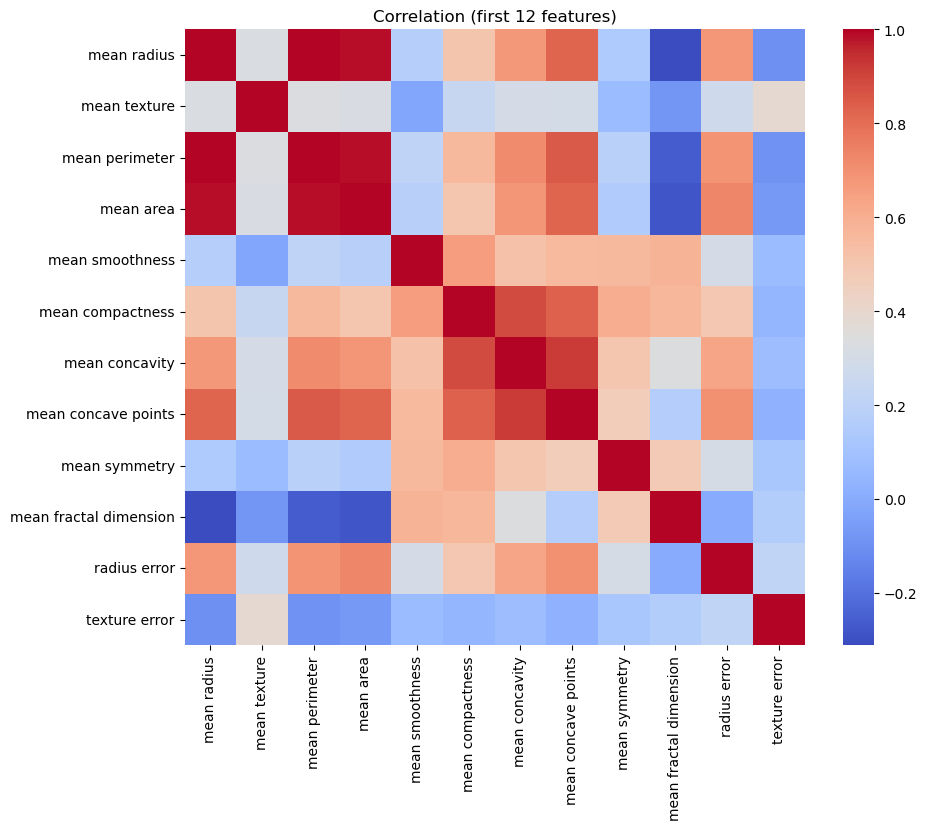

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(X.corr().iloc[:12,:12], cmap='coolwarm')
plt.title("Correlation (first 12 features)")
plt.show()

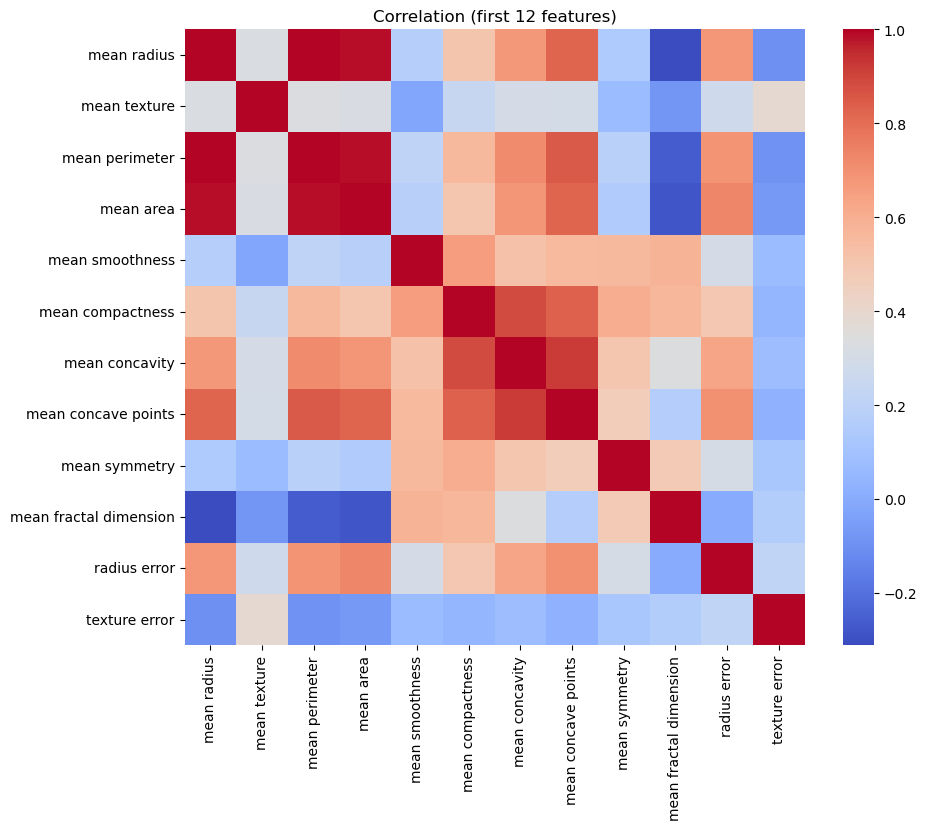

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(X.corr().iloc[:12,:12], cmap='coolwarm')
plt.title("Correlation (first 12 features)")
plt.show()


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train:", X_train.shape, "Test:", X_test.shape)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


Train: (455, 30) Test: (114, 30)


In [20]:
models = {
    "Logistic": LogisticRegression(max_iter=5000),
    "SVM": SVC(probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

cv_results = {}
for name, m in models.items():
    pipe = Pipeline([('scaler', StandardScaler()), ('clf', m)])
    score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy').mean()
    cv_results[name] = round(score, 4)

pd.Series(cv_results).sort_values(ascending=False)


Logistic        0.9802
SVM             0.9714
XGBoost         0.9626
RandomForest    0.9538
dtype: float64

In [21]:
# We'll tune SVM and RandomForest and pick best on CV
from sklearn.model_selection import GridSearchCV

# SVM Grid
pipe_svm = Pipeline([('scaler', StandardScaler()), ('clf', SVC(probability=True))])
param_svm = {
    'clf__kernel': ['rbf'],
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 0.01, 0.001]
}
grid_svm = GridSearchCV(pipe_svm, param_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)
print("Best SVM:", grid_svm.best_params_, "CV acc:", grid_svm.best_score_)

# RandomForest Grid
pipe_rf = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state=42))])
param_rf = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 6, 10],
    'clf__min_samples_split': [2, 4]
}
grid_rf = GridSearchCV(pipe_rf, param_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Best RF:", grid_rf.best_params_, "CV acc:", grid_rf.best_score_)


Best SVM: {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'} CV acc: 0.9802197802197803
Best RF: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200} CV acc: 0.9582417582417582


Selected: SVM
Test Accuracy: 0.9825

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

ROC AUC: 0.9977


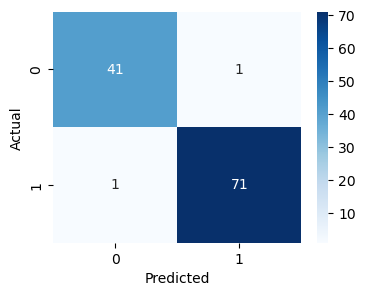

In [22]:
# choose best between grid_svm and grid_rf by CV mean score
if grid_svm.best_score_ >= grid_rf.best_score_:
    best_grid = grid_svm
    print("Selected: SVM")
else:
    best_grid = grid_rf
    print("Selected: RandomForest")

best_model = best_grid.best_estimator_
# Fit on full train (GridSearchCV already fit on folds; ensure final fit)
best_model.fit(X_train, y_train)

# Predictions
y_pred = best_model.predict(X_test)
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test)[:, 1]
else:
    # use decision_function for SVM possibility
    try:
        y_proba = best_model.decision_function(X_test)
    except:
        y_proba = None

print("Test Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification report:\n", classification_report(y_test, y_pred))
if y_proba is not None:
    print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 4))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()


In [24]:
import os
os.makedirs("models", exist_ok=True)
print("models/ directory created or already exists.")


models/ directory created or already exists.


In [25]:
joblib.dump(best_model, 'models/best_model_pipeline.pkl')
print("Saved model to models/best_model_pipeline.pkl")


Saved model to models/best_model_pipeline.pkl


In [27]:
# In-notebook interactive UI using ipywidgets
# Run this cell after you've trained and saved the model OR ensure `models/best_model_pipeline.pkl` exists.

# If ipywidgets not installed, uncomment the next line and run once:
# !pip install -q ipywidgets

import joblib
import numpy as np
from ipywidgets import widgets, VBox, Layout, Output
from IPython.display import display, HTML

# load model (pipeline with scaler + classifier)
model = joblib.load('models/best_model_pipeline.pkl')

# helpful feature list display
try:
    from sklearn.datasets import load_breast_cancer
    feat_names = list(load_breast_cancer().feature_names)
    feat_html = "<b>Feature order (30 features) — same order as sklearn.datasets.load_breast_cancer()</b><br>"
    feat_html += ", ".join(feat_names)
    display(HTML(feat_html))
except:
    pass

out = Output()
txt = widgets.Textarea(
    value='',
    placeholder='Enter 30 feature values separated by commas (same order as sklearn dataset)',
    description='Features:',
    layout=Layout(width='95%', height='90px')
)
btn = widgets.Button(description="Predict", button_style='primary')

def on_predict(b):
    with out:
        out.clear_output()
        s = txt.value.strip()
        if not s:
            print("Please paste 30 comma-separated feature values.")
            return
        try:
            vals = np.fromstring(s, sep=',')
            if vals.size != model.named_steps['clf'].n_features_in_:
                # fallback: check using X shape if pipeline doesn't expose n_features_in_
                try:
                    expected = load_breast_cancer().data.shape[1]
                except:
                    expected = model.named_steps['clf'].n_features_in_ if hasattr(model.named_steps['clf'], 'n_features_in_') else None
                print(f"Error: expected {expected} values but got {vals.size}.")
                return
            vals = vals.reshape(1, -1)
            pred = model.predict(vals)[0]
            # probability for class 1 if available
            proba = model.predict_proba(vals)[0,1] if hasattr(model, 'predict_proba') else None
            label = "Benign (1)" if pred==1 else "Malignant (0)"
            print("Prediction:", label)
            if proba is not None:
                print("Probability (class 1 - benign):", round(float(proba), 4))
        except Exception as e:
            print("Error:", e)

btn.on_click(on_predict)
display(VBox([txt, btn, out]))
